In [1]:
import numpy as np
import torch
import torch.nn as nn
from data_init import class_incremental, Data_Init
from model_config import MyModel_Config
from pytorch_pretrained_bert import BertConfig, BertTokenizer, BertModel, BertForMaskedLM
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
from train_eval import Model_Train
import re
from tqdm import *
import pandas as pd
from pandas import DataFrame
from torch.distributions import Dirichlet

/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
'''调整随机数'''
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(5)

In [3]:
'''利用增量数据初始化处理数据集'''
train_incremental = class_incremental('./data/snips/train.tsv', 'tsv', 64, 7, 5, True, 9999999) #最后的500表示每个类的数据个数限制
train_original_datas, train_incremental_datas_list, train_original_labels, train_all_incremental_labels, labels, label_to_idx = train_incremental.prepare_for_incremental()
train_Joint_datasets = train_incremental.Joint_incremental()

#初始化验证集的原始类和增量类数据
dev_incremental = class_incremental('./data/snips/dev.tsv', 'tsv', 64, 7, 5, True, 999999, 'eval', labels, label_to_idx)
dev_original_datas, dev_incremental_datas_list, dev_original_labels, dev_all_incremental_labels = dev_incremental.prepare_for_incremental()
dev_Joint_datasets = dev_incremental.Joint_incremental()

#初始化测试集的原始类和增量类数据
test_incremental = class_incremental('./data/snips/test.tsv', 'tsv', 64, 7, 5, True, 9999999, 'eval', labels, label_to_idx)
test_original_datas, test_incremental_datas_list, test_original_labels, test_all_incremental_labels = test_incremental.prepare_for_incremental()
test_Joint_datasets = test_incremental.Joint_incremental()

In [4]:
'''定义训练模型'''
class Teachermodel(nn.Module):
    def __init__(self,config):
        super(Teachermodel,self).__init__()
        self.bert=BertModel.from_pretrained(config.bert_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
 
        
        self.dropout=nn.Dropout(config.dropout)

        self.fc = nn.Linear(768, config.num_classes ) 


    def forward(self, tokens):

        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
     
        out=self.fc(encoder_out[:,0,:])
 
        out = self.dropout(out)
        
        return out


In [5]:
'''student模型'''
class Bert_student(nn.Module):
    def __init__(self,config):
        super(Bert_student,self).__init__()
        self.bert=BertModel.from_pretrained(config.bertmini_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
        
        self.dropout=nn.Dropout(config.dropout)
        self.fc = nn.Linear(256, config.num_classes ) 


    def forward(self, tokens):

    
        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
        out=self.fc(encoder_out[:,0,:])
        out = self.dropout(out)
        
        return out

In [6]:
class Model_Train_ipynb(object):
    def __init__(self, isTPCIL=False): #
        #self.epochs = MyModel_Config.epochs #训练几个epochs
        self.device = 'cuda:0'
        self.isTPCIL = isTPCIL
        
    '''测试集和验证集的精度计算,用于全体验证集或测试集的精度计算
    model：要评估的模型
    datapath：输入字符串如'./data/snips/valid.csv'，表明要测试的验证集或测试集路径
    mode:输入字符串'csv'或'tsv' ，表明要测试的文件格式'''
    def my_eval(self, model, datapath, loss_func, mode, label_to_idx_train):
        device = self.device
        tensor_datas, labels_idx = Data_Init(datapath, 64, mode, 'eval', label_to_idx_train).datas_to_tensors()#输出都是tensor形式

        model = model.to(device)
        model.eval() #eval()将我们的模型置于评估模式，而不是训练模式。在这种情况下，评估模式关闭了训练中使用的dropout正则化。
        accuracy=0
        loss_sum=0
        with torch.no_grad():
            for idx, datas in enumerate(tensor_datas):
                tokens = datas[0].to(device)  #tokens输入到bert里得到[batch_size, seq_len, embedding_size]的embedding
                labels_idx = datas[1].to(device)
                
                if self.isTPCIL == False:
                    probs = model(tokens).squeeze()  #去除掉[batch_size, 1, len(classes)]中的1维度
                elif self.isTPCIL == True:
                    _, probs = model(tokens)  #去除掉[batch_size, 1, len(classes)]中的1维度
                    probs.squeeze()
                loss = loss_func(probs, labels_idx) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
                #虽然这里的probs没有经过softmax处理，但也可以用下面的这个argmax公式，因为softmax不会改变原本数值元素的大小排名
                accuracy += (labels_idx == torch.argmax(probs, dim=1)).sum()  #计算预测标签和真实标签相等的数量
                loss_sum+=loss.item() #计算所有样本/batch的loss
                
                last_size = len(datas[1])  #用于保存最后一个batch有多少数据

        accuracy = accuracy / (idx*tensor_datas.batch_size + last_size)
        accuracy = accuracy.item()
        model.train()#从eval模式回到train模式

        return accuracy, loss_sum
    
    '''由于增量学习要求对相应的增量类和原始类数据进行精度的计算，所以如果直接输入验证集路径进去，会导致计算所有类精度，所以这里输入变为直接输入数据
    model:要进行精度计算的模型
tensor_datas:验证集/测试集的经过Dataloader封装的数据
loss_function:用于计算验证集/测试集损失'''

    def eval_for_incremental(self, model, tensor_datas, loss_function):
        device = self.device
        model = model.to(device)

        accuracy=0
        loss_sum=0
    
        model.eval() #关闭模型dropout
        with torch.no_grad():
            idx = 0
            for idx, datas in enumerate(tensor_datas):
                tokens = datas[0].to(device)  #tokens输入到bert里得到[batch_size, seq_len, embedding_size]的embedding
                labels_idx = datas[1].to(device)
                
                if self.isTPCIL == False:
                    probs = model(tokens).squeeze()  #去除掉[batch_size, 1, len(classes)]中的1维度
                elif self.isTPCIL == True:
                    _, probs = model(tokens)  #去除掉[batch_size, 1, len(classes)]中的1维度
                    probs.squeeze()
                loss = loss_function(probs, labels_idx) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
            
                accuracy += (labels_idx == torch.argmax(probs, dim=1)).sum()  #计算预测标签和真实标签相等的数量
                loss_sum+=loss.item() #计算所有样本/batch的loss
                
                last_size = len(datas[1])  #用于保存最后一个batch有多少数据

        accuracy = float(accuracy) / (idx*tensor_datas.batch_size + last_size)

        model.train()#从eval模式回到train模式

        return accuracy, loss_sum
#用法：
#eval_for_incremental(model, tensor_datas, loss_function),用法在incremental_learning文件的类中

    def eval_for_embeddingKD(self, teacher_embed_model, student_revise, tensor_datas, loss_function):
        device = self.device
        teacher_embed_model = teacher_embed_model.to(device)
        student_revise = student_revise.to(device)

        accuracy=0
        loss_sum=0
    
        teacher_embed_model.eval() #关闭模型dropout
        student_revise.eval()
        with torch.no_grad():
            idx = 0
            for idx, datas in enumerate(tensor_datas):
                tokens = datas[0].to(device)  #tokens输入到bert里得到[batch_size, seq_len, embedding_size]的embedding
                labels_idx = datas[1].to(device)

                teacher_embed = teacher_embed_model(tokens)
                probs = student_revise(teacher_embed)

                loss = loss_function(probs, labels_idx) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
            
                accuracy += (labels_idx == torch.argmax(probs, dim=1)).sum()  #计算预测标签和真实标签相等的数量
                loss_sum+=loss.item() #计算所有样本/batch的loss
                
                last_size = len(datas[1])  #用于保存最后一个batch有多少数据

        accuracy = float(accuracy) / (idx*tensor_datas.batch_size + last_size)

        student_revise.train()#从eval模式回到train模式

        return accuracy, loss_sum


    '''参数：
    model：训练模型
    loss_func:损失函数
    optimizer:优化器
    epochs:迭代次数
    tensor_datas:要输入的Dataloader封装的数据，默认为MyModel_Config里面的数据
    datapath_eval: 如果等于'none'说明不对验证集或测试集进行每个batch训练后的精度和损失计算；如果等于验证集或测试集路径，则进行计算
    eval_mode：验证集或测试集的格式，为'csv'或'tsv'.
    label_to_idx_train:训练集的标签字典，只有当datapath_eval不为none时候才设置初值'''
    def my_train(self, model, loss_func, optimizer, epochs, tensor_datas, datapath_eval='none', eval_mode='csv', label_to_idx_train={}): #增加了需要自己输入的epochs
        device = self.device
        #epochs = self.epochs
        model.train()

        model = model.to(device)
        losses = [] #存放所有样本一个epoch的损失
        accuracies = []
        iter = [] #用于绘图的横坐标

        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
        for epoch in tqdm(range(epochs)):
            
            '''对每个batch的训练'''
            for idx, datas in enumerate(tensor_datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
                tokens = datas[0].to(device)
                labels = datas[1].to(device)
                #labels_one_hot = datas[1].to(device)  #one-hot形式标签，用于损失计算，[batch_size, labels_nums]
                #labels = torch.topk(labels_one_hot, 1)[1].view(-1,1)   #要计算精度，就需要非one-hot形式的标签，转化为(batch_size,1)形式的标签
        
                optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
                if self.isTPCIL == False:
                    probs = model(tokens).squeeze()  #去除掉[batch_size, 1, len(classes)]中的1维度
                elif self.isTPCIL == True:
                    _, probs = model(tokens)  #去除掉[batch_size, 1, len(classes)]中的1维度
                    probs.squeeze()
                loss = loss_func(probs, labels) #"host_softmax" not implemented for 'Long'错误出现，如果预测值和标签写反
                loss.backward()
                optimizer.step()
                #scheduler.step()#学习率递减
            accuracy_train, loss_sum = self.eval_for_incremental(model, tensor_datas, loss_func)
    
            if datapath_eval != 'none': 
                if label_to_idx_train == {}:
                    raise ValueError("要输出测试集精度模式下需要输入训练集对应的标签字典")
                accuracy_eval, loss_eval = self.my_eval(model, datapath_eval, loss_func, eval_mode, label_to_idx_train)
                print('第'+str(epoch)+'的验证集失为：'+str(loss_eval))
                print('第'+str(epoch)+'的验证集精度为：'+str(accuracy_eval))
            
            accuracies.append(accuracy_train) #accuracy上的数据在cuda上，需要放到cpu上才能作图，而loss.item()已经加到cpu上了
            losses.append(loss_sum)
            iter.append(epoch)
            #print("the loss of  training data "+ str(epoch) + "  is-----------" + str(loss_sum))
            #print("the accuracy of training data   "+ str(epoch) + "  is-----------" + str(accuracy_train))
    
        #plt.figure(1)
        #plt.title("loss of epoch per————"+str(loss_func)+ ","+ str(epochs)+ "epochs")
        #plt.xlabel("loss per epoch")
        #plt.ylabel("LOSS")
        #plt.plot(iter, losses)

        #plt.figure(2)
        #plt.title("accuracy of epoch per————"+str(accuracy_train)+ ","+ str(epochs)+ "epochs")
        #plt.xlabel("accuracy per epoch")
        #plt.ylabel("ACCURACY")
        #plt.plot(iter, accuracies)

        #plt.show()
        return accuracies, losses

In [10]:
'''teacher模型,embedding层的参数不可修改'''
class Teachermodel_revise(nn.Module):
    def __init__(self,teacher_model, device):
        super(Teachermodel_revise,self).__init__()
        
        self.device = device

        self.teacher_model_embedding = teacher_model.bert.embeddings
        for param in self.teacher_model_embedding.parameters():    
            param.requires_grad = False

        self.teacher_model_encoder = teacher_model.bert.encoder
        for param in self.teacher_model_encoder.parameters():    
            param.requires_grad = True

        self.teacher_model_remain = teacher_model.bert.pooler   #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错

        for param in self.teacher_model_remain.parameters():    
            param.requires_grad = True   #冻结teahcer model所有剩余层的参数，不进行梯度更新

        self.teacher_model_dropout = teacher_model.dropout
                                                      
        for param in self.teacher_model_dropout.parameters():
            param.requires_grad = True
        
        self.teacher_model_fc = teacher_model.fc
                                                      
        for param in self.teacher_model_fc.parameters():
            param.requires_grad = True
        


    def forward(self, tokens):
        out = self.teacher_model_embedding(tokens)
        
        out = self.teacher_model_encoder(out, attention_mask=torch.tensor([1]).to(self.device)) #输入(batch_size, seq_len, embedding_size)的tokens embedding, 输出(batch_size, num_classes)的out
        pooled_output = self.teacher_model_remain(out[-1])  #out[-1]代表最后一个encoder的输出,pooler层直接输出[CLS]的

        probs = self.teacher_model_dropout(pooled_output)
        probs = self.teacher_model_fc(probs)
        
        return probs 
        

In [12]:
'''利用原始数据训练并保存Teacher model'''
print('*******************原始数据训练Teacher model**********************')
teacher_model = Teachermodel(MyModel_Config(train_original_labels))
teacher_model_reviese = Teachermodel_revise(teacher_model, 'cuda:0')
optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train_ipynb().my_train(teacher_model_reviese, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train_ipynb().eval_for_incremental(teacher_model_reviese, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train_ipynb().eval_for_incremental(teacher_model_reviese, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))

*******************原始数据训练Teacher model**********************


100%|██████████| 10/10 [08:09<00:00, 48.97s/it]


训练集精度变化[0.9781709558823529, 0.9898897058823529, 0.9934895833333334, 0.9957873774509803, 0.99609375, 0.9980085784313726, 0.9966299019607843, 0.9980085784313726, 0.9990042892156863, 0.999234068627451]
验证集最终精度0.990625
测试集最终精度0.9828125


In [13]:
last_layer_weight = teacher_model_reviese.teacher_model_fc.weight.detach().to('cpu')  #去除梯度
concent_params = torch.zeros([last_layer_weight.shape[0], last_layer_weight.shape[0]])
for i in range(len(last_layer_weight)):
    for j in range(len(last_layer_weight)):
        param = torch.matmul(last_layer_weight[i],last_layer_weight[j])
        param = param / (torch.norm(last_layer_weight[i]) * torch.norm(last_layer_weight[j]))  #计算最后一层权重的关系
        concent_params[i][j] = param
        
    max_val = torch.max(concent_params[i])
    min_val = torch.min(concent_params[i])
    concent_params[i] = (concent_params[i] - min_val + 1e-7) / (max_val-min_val)   #加上1e-7防止有0存在
    
labels = train_original_labels #绘图用到的标签

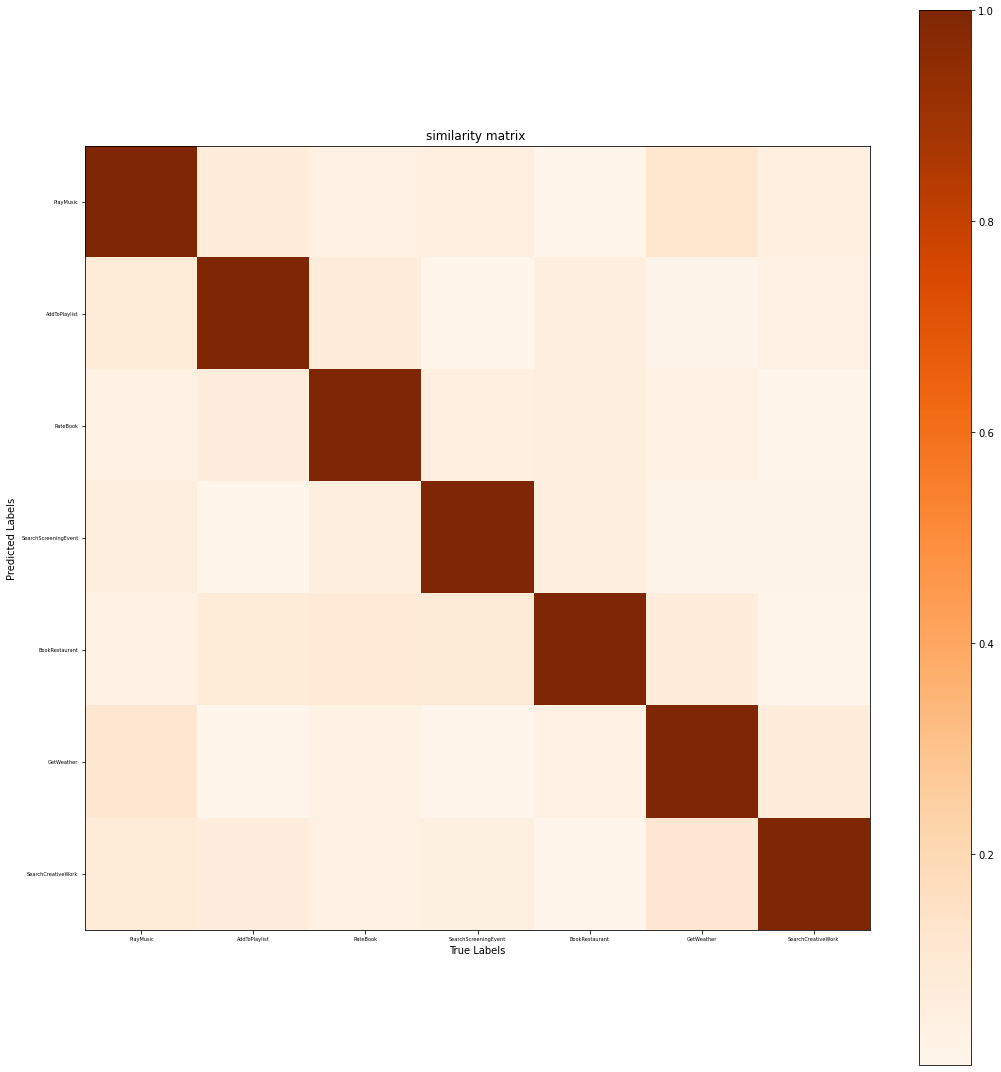

In [14]:
'''相似度矩阵绘制'''
def similar_matrix_plot(concent_params, num_classes, labels):#绘制混淆矩阵
    matrix = concent_params.numpy()  #先放在numpy上才能作图
    plt.figure(figsize=(15,15))  #设置画布大小
    plt.imshow(matrix, cmap=plt.cm.Oranges)
  
    # 设置x轴坐标label
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, labels,fontsize=5)
    plt.yticks(tick_marks, labels,fontsize=5)
        # 显示colorbar
    plt.colorbar()
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('similarity matrix ')

    plt.tight_layout()
    plt.show()

similar_matrix_plot(concent_params, len(train_original_labels), labels)

In [15]:
'''通过teacher model和direclet samples训练生成DI的embeddings，用于蒸馏student model
DIemb_Gen_model:用于生成DI embedding的模型
dir_samples:用Dataloader包装的迪利克雷分布及其标签
opitmizer:用于优化DIemb_Gen_model
loss_func:KL散度
loss_func2:交叉熵
'''
def train_DI_Embeddings_gen(DIemb_Gen_model, DIemb_datasets, optimizer, loss_func, loss_func2, temper=10, error=0.3, batch_size=64, max_iter=True):
    device = 'cuda:0'
    loss_num=999
    DIemb_Gen_model = DIemb_Gen_model.to(device)
    embeddings = torch.tensor([]).to(device)  #用于存放最终生成的tokens embeddings
    embedding_labels = torch.tensor([]).to(device)

    for _, data in tqdm(enumerate(DIemb_datasets)):
            
        dir_samples = data[0].to(device)
        labels = data[1].long().to(device)

        z = torch.randn(batch_size,30,768).to(device)   #噪声为[batch_size, seq_len, embedding_size]形式输入到改动了embedding层后的teacher model

        tokensemb_gens = torch.tensor([]).to(device)
        emb_probs = torch.tensor([]).to(device)
        losses = torch.tensor([]) #保存对应的损失
        count = 0
        loss_num = 999
        while loss_num > error:  
            
            if max_iter == True and count>=300:  #是否设置最大迭代次数1200
                break
            
            optimizer.zero_grad()
            probs, emb_gens = DIemb_Gen_model(z)
            
            loss = loss_func(F.log_softmax(probs / temper, dim=1), dir_samples) + 0.6*loss_func2(probs, labels)

            loss_num = loss.item()
            
            loss.requires_grad_(True) #这里应该是因为如果将最后一层的模型参数梯度关闭，则计算出来的loss也没有梯度，不能追踪，所以要将loss的梯度设置为True
            loss.backward()
            optimizer.step()
            
            loss_num = loss.item()
            count += 1
            
            if count%2==0:
                tokensemb_gens = torch.cat([tokensemb_gens, emb_gens], dim=0)
                emb_probs = torch.cat([emb_probs, probs], dim=0)
                losses = torch.cat([losses, torch.tensor([loss_num])])
                #print(loss_num)
        #print('训练过程中teacher model的预测情况'+str(torch.argmax(probs)))
            
        if max_iter == True and len(tokensemb_gens) > 0:
            num = torch.argmin(losses).item()
            tokensemb_gen = tokensemb_gens[num*batch_size : (num+1)*batch_size]  #选择loss最小的
            emb_probs_batch = emb_probs[num*batch_size : (num+1)*batch_size]
        
        embeddings = torch.cat([embeddings, tokensemb_gen], dim=0)
        emb_label = torch.argmax(emb_probs_batch, dim=1)  #找到对应的标签
        embedding_labels = torch.cat([embedding_labels, emb_label], dim=0)
            
    return embeddings.detach(), embedding_labels.detach()

In [16]:
'''用于生成DI_embedding数据印象的模型'''
class DIemb_Gen_model(nn.Module):
    def __init__(self, teacher_model, device):
        super(DIemb_Gen_model,self).__init__()
        self.device = device
        self.fc1 = nn.Linear(768,1024)
        self.fc2 = nn.Linear(1024,768)       #用于训练网络生成符合条件的噪声
        
        self.teacher_model_encoder = teacher_model.bert.encoder
        for param in self.teacher_model_encoder.parameters():    
            param.requires_grad = False

        self.teacher_model_remain = teacher_model.bert.pooler   #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错

        for param in self.teacher_model_remain.parameters():    
            param.requires_grad = False   #冻结teahcer model所有剩余层的参数，不进行梯度更新

        self.teacher_model_classifier = nn.Sequential(teacher_model.dropout,
                                                      teacher_model.fc)
        for param in self.teacher_model_classifier.parameters():
            param.requires_grad = False


    def forward(self, z):
        out = self.fc1(z)
        out = torch.relu(out)
        emb_gen = self.fc2(out)
        self.teacher_model_encoder.eval()
        self.teacher_model_remain.eval()
        
        out = self.teacher_model_encoder(emb_gen, attention_mask=torch.tensor([1]).to(self.device)) #输入(batch_size, seq_len, embedding_size)的tokens embedding, 输出(batch_size, num_classes)的out
        pooled_output = self.teacher_model_remain(out[-1])  #out[-1]代表最后一个encoder的输出,pooler层直接输出[CLS]的

        probs = self.teacher_model_classifier(pooled_output)   
        
        return probs, emb_gen

In [17]:
'''生成并打包迪利克雷分布采样进入Dataloader中,并且定义模型和损失函数,优化器'''
dir_samples = torch.tensor([])
dir_labels = torch.tensor([])
DIemb_num = 10000
for i in tqdm(range(len(train_original_labels))):  #标签的idx刚好和train_original_labels的下标顺序对应

    for k in [1,5]:  #每种β生成1/2的数据
        m = Dirichlet(k*concent_params[i])  #采样每个类的数据
        
        for j in range(int(DIemb_num/len(train_original_labels)/2)):

            x = m.sample().view(1,-1)

            dir_samples = torch.cat([dir_samples, x], dim=0)
            dir_labels = torch.cat([dir_labels,torch.tensor([i]).long()], dim=0)
            
dirsample_datasets = TensorDataset(dir_samples, dir_labels)
dirsample_datasets = DataLoader(dirsample_datasets, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

model = DIemb_Gen_model(teacher_model, 'cuda:0')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

100%|██████████| 7/7 [00:00<00:00,  9.92it/s]


In [18]:
'''训练生成tokens embedding'''
embeddings_gen, embedding_labels = train_DI_Embeddings_gen(model, dirsample_datasets, optimizer, loss_func, loss_func2)
embedding_gen = embeddings_gen.to('cpu')
embedding_labels = embedding_labels.to('cpu')

0it [00:00, ?it/s]/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
156it [03:26,  1.32s/it]


In [19]:
DIemb_datasets = TensorDataset(embedding_gen, embedding_labels)   #这里不用detach接下来就不能训练
DIemb_datasets = DataLoader(DIemb_datasets, batch_size=128, shuffle=True, drop_last=True)

In [20]:
labels = torch.tensor([])
for i, data in enumerate(DIemb_datasets):
    labels = torch.cat([labels, data[1]], dim=0)


In [21]:
'''标签更加均衡'''
label_idx = {}
for i in range(len(train_original_labels)):
    label_idx[i] = 0

for i in range(len(labels)):
    label_idx[labels[i].item()] += 1
print(label_idx)

{0: 1441, 1: 1430, 2: 1419, 3: 1428, 4: 1431, 5: 1412, 6: 1423}


In [22]:
'''尝试2019DI的zero-shot蒸馏student模型的训练函数
参数：
teacher_model:被提取的模型
student_model:要提取出的模型
datas:DI生成的数据，用Dataloader封装
optimizer:优化器，只优化student_model的参数
loss_func:采用KL散度，或是MSE等保持teacher和student的softmax输出的相似性
temper:KL散度的温度系数,不能设置太高，经过实验探究，设置到4左右效果最好
'''
def train_KD_student(teacher_model_embedding, teacher_model, student_model, datas, optimizer, loss_func, loss_func2, temper, epochs , train_original_datas, dev_original_datas, test_original_datas):
    device = 'cuda:0'
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    teacher_model_embedding = teacher_model_embedding.to(device)
    teacher_model_embedding.eval()
    teacher_model.eval()
    student_model.train()
    
    losses = [] #存放所有样本一个epoch的损失
    accuracies = []
    
    max_acc_fin = 0 #记录最终最大精度测试集组并输出
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
    for epoch in tqdm(range(epochs)):
        max_acc_test = 0
        '''对每个batch的训练'''
        for idx, data in enumerate(datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
            student_model.train()
            tokens_embedding = data[0].to(device)
            #labels = data[1].to(device)
        
            optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
            
        
            probs_teacher = teacher_model(tokens_embedding)
            
            probs_student = student_model(tokens_embedding)
            
            loss = loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1))
            #loss = 0.8*loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1)) + 0.2*loss_func2(probs_student, labels)
            loss.backward(retain_graph=True)  #这里不用loss.requires_grad_(True)的原因是优化器优化的参数中间步骤不包括梯度不动的teacher_model
            optimizer.step()
            #scheduler.step()#学习率递减
            print(loss.item())
            
            student_model.eval()
            accuracy_test, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model_embedding, student_model, test_original_datas, loss_func2)
            
            if max_acc_test<accuracy_test:
                max_acc_test = accuracy_test
                accuracy_train, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model_embedding, student_model, train_original_datas, loss_func2)
                accuracy_dev, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model_embedding, student_model, dev_original_datas, loss_func2)
        
        print('训练集精度'+str(accuracy_train))
        print('验证集精度'+str(accuracy_dev))
        print('测试集精度'+str(max_acc_test))
        
        if max_acc_fin<max_acc_test:
            max_acc_fin = max_acc_test
            accuracy_train_fin = accuracy_train
            accuracy_dev_fin = accuracy_dev

        student_model.train()
    
    print('训练集最终精度'+str(accuracy_train_fin))
    print('验证集最终精度'+str(accuracy_dev_fin))
    print('测试集最终精度'+str(max_acc_fin))
               

In [23]:
'''定义用于蒸馏的模型'''
class Teachermodel_revise(nn.Module):
    def __init__(self,teacher_model, device):
        super(Teachermodel_revise,self).__init__()

        self.device = device

        self.teacher_model_encoder = teacher_model.bert.encoder
        for param in self.teacher_model_encoder.parameters():    
            param.requires_grad = False

        self.teacher_model_remain = teacher_model.bert.pooler   #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错

        for param in self.teacher_model_remain.parameters():    
            param.requires_grad = False   #冻结teahcer model所有剩余层的参数，不进行梯度更新

        self.teacher_model_classifier = nn.Sequential(teacher_model.dropout,
                                                      teacher_model.fc)
        for param in self.teacher_model_classifier.parameters():
            param.requires_grad = False


    def forward(self, tokens_embedding):
        
        out = self.teacher_model_encoder(tokens_embedding, attention_mask=torch.tensor([1]).to(self.device)) #输入(batch_size, seq_len, embedding_size)的tokens embedding, 输出(batch_size, num_classes)的out
        pooled_output = self.teacher_model_remain(out[-1])  #out[-1]代表最后一个encoder的输出,pooler层直接输出[CLS]的

        probs = self.teacher_model_classifier(pooled_output) 
        
        return probs



'''student模型'''
class Studentmodel_revise(nn.Module):
    def __init__(self,student_model, device, teacher_dim=768, student_dim=768):
        super(Studentmodel_revise,self).__init__()
        
        self.device = device

        #self.fc1 = nn.Linear(teacher_dim, 1024)
        #self.fc2 = nn.Linear(1024, student_dim)

        self.student_model_encoder = student_model.bert.encoder
        for param in self.student_model_encoder.parameters():    
            param.requires_grad = True

        self.student_model_remain = student_model.bert.pooler   #这里由于nn.Sequential只能接收单独输入，所以encoder需要两个输入[embedding, attention_mask]，但是sequential不能接受两个收入，就会报错

        for param in self.student_model_remain.parameters():    
            param.requires_grad = True   #冻结teahcer model所有剩余层的参数，不进行梯度更新

        self.student_model_classifier = nn.Sequential(student_model.dropout,
                                                      student_model.fc)
        for param in self.student_model_classifier.parameters():
            param.requires_grad = True


    def forward(self, tokens_embedding):
        #out = self.fc1(tokens_embedding)
        #out = torch.tanh(out)
        #out = self.fc2(out)
        
        out = self.student_model_encoder(tokens_embedding, attention_mask=torch.tensor([1]).to(self.device)) #输入(batch_size, seq_len, embedding_size)的tokens embedding, 输出(batch_size, num_classes)的out
        pooled_output = self.student_model_remain(out[-1])  #out[-1]代表最后一个encoder的输出,pooler层直接输出[CLS]的

        probs = self.student_model_classifier(pooled_output)
        
        return probs 
        

In [25]:
'''定义用zero-shot KD训练的student模型和损失函数和优化器'''

print('*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************')

bert_student = Teachermodel(MyModel_Config(train_original_labels))
student_revise = Studentmodel_revise(bert_student, 'cuda:0')
teacher_revise = Teachermodel_revise(teacher_model, "cuda:0")

optimizer = torch.optim.AdamW(student_revise.parameters(), lr=1e-5)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

accuracy_train, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model.bert.embeddings, student_revise, train_original_datas, loss_func2)
accuracy_dev, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model.bert.embeddings, student_revise, dev_original_datas, loss_func2)
accuracy_test, _ = Model_Train_ipynb().eval_for_embeddingKD(teacher_model.bert.embeddings, student_revise, test_original_datas, loss_func2)
print(accuracy_train)
print(accuracy_dev)
print(accuracy_test)

train_KD_student(teacher_model.bert.embeddings, teacher_revise, student_revise, DIemb_datasets, optimizer, loss_func, loss_func2, 5, 30, train_original_datas, dev_original_datas, test_original_datas)

*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************
0.1448376225490196
0.146875
0.1453125


  0%|          | 0/30 [00:00<?, ?it/s]

0.009786389768123627
0.010480468161404133
0.009848935529589653
0.010290158912539482
0.009549036622047424
0.009586542844772339
0.009305066429078579
0.01004403829574585
0.00946862157434225
0.009270223788917065
0.010301705449819565
0.008950476534664631
0.009691943414509296
0.009045371785759926
0.00945785641670227
0.009237909689545631
0.0097710145637393
0.00957106426358223
0.009280693717300892
0.00968222040683031
0.009299893863499165
0.009740900248289108
0.01052599586546421
0.00994446687400341
0.00989268533885479
0.009451551362872124
0.00935200322419405
0.00972864218056202
0.009685925208032131
0.00899769738316536
0.00971146859228611
0.009951695799827576
0.009569428861141205
0.009816705249249935
0.009954008273780346
0.009737934917211533
0.009664103388786316
0.009814813733100891
0.009404798038303852
0.010313047096133232
0.009154317900538445
0.009052249602973461
0.00942167080938816
0.009644653648138046
0.00905646663159132
0.00991235114634037
0.009481596760451794
0.009557430632412434
0.0095404

  3%|▎         | 1/30 [02:08<1:02:07, 128.54s/it]

训练集精度0.14476102941176472
验证集精度0.1421875
测试集精度0.159375
0.00913891103118658
0.009418470785021782
0.010003295727074146
0.009424984455108643
0.0097428597509861
0.00901773851364851
0.009203930385410786
0.010098590515553951
0.009589025750756264
0.009240569546818733
0.009333135560154915
0.009275304153561592
0.009684333577752113
0.009522383101284504
0.009117539040744305
0.009040726348757744
0.00973618682473898
0.009163230657577515
0.009789982810616493
0.009367311373353004
0.008600692264735699
0.008547092787921429
0.009241553023457527
0.009188114665448666
0.009243331849575043
0.009164391085505486
0.00974983535706997
0.008936494588851929
0.009613022208213806
0.009669849649071693
0.00929801631718874
0.009603545069694519
0.009659024886786938
0.009204132482409477
0.009692007675766945
0.009656903333961964
0.0088634192943573
0.009405906312167645
0.009444421157240868
0.009667234495282173
0.008994286879897118
0.009389355778694153
0.009544993750751019
0.00980977714061737
0.009547632187604904
0.009443191

  7%|▋         | 2/30 [03:52<53:18, 114.25s/it]  

训练集精度0.1448376225490196
验证集精度0.1453125
测试集精度0.15625
0.008294584229588509
0.009247592650353909
0.008977551944553852
0.00869415421038866
0.008941789157688618
0.009200788103044033
0.009278959594666958
0.009560111910104752
0.009747225791215897
0.008795867674052715
0.009852927178144455
0.00937377568334341
0.009405422955751419
0.00946707185357809
0.009256799705326557
0.008974249474704266
0.009291792288422585
0.008694957010447979
0.008988900110125542
0.010172133333981037
0.009351122193038464
0.009279227815568447
0.0098806731402874
0.01000208966434002
0.009313656017184258
0.009513268247246742
0.009626874700188637
0.009042046032845974
0.008912567049264908
0.009248606860637665
0.009549024514853954
0.008637446910142899
0.009742021560668945
0.008792146109044552
0.00857611931860447
0.008805041201412678
0.009329459629952908
0.008522416464984417
0.008815089240670204
0.009506589733064175
0.009016230702400208
0.00879200454801321
0.008935431018471718
0.009160554967820644
0.008841989561915398
0.008873603

 10%|█         | 3/30 [06:01<54:25, 120.95s/it]

训练集精度0.1451439950980392
验证集精度0.1484375
测试集精度0.1578125
0.00856431107968092
0.009378282353281975
0.008796040900051594
0.009219743311405182
0.007860688492655754
0.008807271718978882
0.00834702979773283
0.00901343859732151
0.008833706378936768
0.008798163384199142
0.008245292119681835
0.009067635983228683
0.008541546761989594
0.00873959343880415
0.008632732555270195
0.008190007880330086
0.008854863233864307
0.008634003810584545
0.008524132892489433
0.009141300804913044
0.008856216445565224
0.008887412957847118
0.00981789268553257
0.00876941904425621
0.008895284496247768
0.009756912477314472
0.009283591993153095
0.008432779461145401
0.00852157175540924
0.008867483586072922
0.0088728629052639
0.00914289802312851
0.009582743048667908
0.008561477065086365
0.008644417859613895
0.00824066624045372
0.008700813166797161
0.008862528018653393
0.00784559827297926
0.008543897420167923
0.00847107544541359
0.008216517977416515
0.00883704237639904
0.008457270450890064
0.009437652304768562
0.0086160125210

 13%|█▎        | 4/30 [08:23<55:54, 129.02s/it]

训练集精度0.14491421568627452
验证集精度0.146875
测试集精度0.15625
0.009170686826109886
0.008268756791949272
0.008677845820784569
0.008366928435862064
0.007385101169347763
0.008057505823671818
0.008151490241289139
0.008819321170449257
0.00865598302334547
0.008125290274620056
0.008944946341216564
0.008379379287362099
0.008453527465462685
0.00833154283463955
0.008290914818644524
0.008898900821805
0.008206838741898537
0.008168785832822323
0.00785507820546627
0.00807005725800991
0.007920078001916409
0.008702335879206657
0.007684976328164339
0.008202102035284042
0.00777279632166028
0.008949989452958107
0.008523453958332539
0.008142267353832722
0.008339140564203262
0.008313830941915512
0.008072796277701855
0.008103247731924057
0.008399385958909988
0.008143439888954163
0.008034874685108662
0.008302287198603153
0.007551841903477907
0.008852038532495499
0.008156408555805683
0.008449049666523933
0.008323965594172478
0.00820193812251091
0.008410781621932983
0.007624363526701927
0.007696385495364666
0.0087959142

 17%|█▋        | 5/30 [10:31<53:43, 128.96s/it]

训练集精度0.14476102941176472
验证集精度0.14375
测试集精度0.15625
0.008055659011006355
0.008287635631859303
0.007603941485285759
0.008481435477733612
0.007904731668531895
0.008098956197500229
0.007448432967066765
0.0071516865864396095
0.007457395549863577
0.008499501273036003
0.008726758882403374
0.007636253256350756
0.008054619655013084
0.008081557229161263
0.007590834982693195
0.00829743966460228
0.007996617816388607
0.007852448150515556
0.007736916188150644
0.0074063865467906
0.008423996157944202
0.008065418340265751
0.00816652737557888
0.007947525009512901
0.007951637730002403
0.00824800319969654
0.00743267685174942
0.008093699812889099
0.007810535375028849
0.007611532229930162
0.00816372036933899
0.007697349414229393
0.00815504789352417
0.008024530485272408
0.007773433346301317
0.007276443764567375
0.007459568325430155
0.008357269689440727
0.007692182902246714
0.008265047334134579
0.007858245633542538
0.007370476145297289
0.008817416615784168
0.008214295841753483
0.008077372796833515
0.007532060

 20%|██        | 6/30 [12:40<51:33, 128.88s/it]

训练集精度0.1449908088235294
验证集精度0.1390625
测试集精度0.1578125
0.00737786153331399
0.0070479451678693295
0.007276555988937616
0.007250362541526556
0.0075102560222148895
0.006997032556682825
0.008160088211297989
0.007901903241872787
0.0072957901284098625
0.007827211171388626
0.007481020875275135
0.007306548301130533
0.0070727490819990635
0.007383821532130241
0.008010964840650558
0.007407289929687977
0.007030557841062546
0.00707058422267437
0.007341956719756126
0.008499842137098312
0.0076660760678350925
0.0074136205948889256
0.00751511100679636
0.007376356050372124
0.00728701613843441
0.00760766351595521
0.007038449868559837
0.006985468789935112
0.007123585790395737
0.007809672504663467
0.00765333091840148
0.00733885308727622
0.008021092042326927
0.00777798518538475
0.007587017025798559
0.0074029285460710526
0.006965425331145525
0.007968801073729992
0.007876160554587841
0.007833522744476795
0.00738931680098176
0.007171649485826492
0.007803283631801605
0.008541656658053398
0.006960025988519192
0.0

 23%|██▎       | 7/30 [14:49<49:23, 128.86s/it]

训练集精度0.14506740196078433
验证集精度0.1421875
测试集精度0.159375
0.006599925924092531
0.006914184894412756
0.006929730996489525
0.007345097605139017
0.006726579740643501
0.006695254240185022
0.007095721550285816
0.007492909673601389
0.00666439812630415
0.006760085001587868
0.006874254904687405
0.007335389032959938
0.00681355269625783
0.006879270076751709
0.00680105946958065
0.006920833606272936
0.007342856377363205
0.007510263938456774
0.007727432996034622
0.007213521748781204
0.007454319391399622
0.007516182027757168
0.006982198916375637
0.00833512656390667
0.006996334996074438
0.007083775941282511
0.0072858622297644615
0.007004468701779842
0.0066480254754424095
0.00711805559694767
0.007731368765234947
0.006816284265369177
0.006782939191907644
0.007176508195698261
0.007870889268815517
0.006951454095542431
0.007553952746093273
0.007869738154113293
0.0072823637165129185
0.007563053630292416
0.007063394412398338
0.006559084635227919
0.007029412314295769
0.006677625700831413
0.006876920349895954
0.0

 27%|██▋       | 8/30 [16:58<47:14, 128.86s/it]

训练集精度0.14476102941176472
验证集精度0.1359375
测试集精度0.15625
0.006388944573700428
0.006428752560168505
0.006902641151100397
0.006554604507982731
0.006749196909368038
0.006476281210780144
0.006113356910645962
0.006623199675232172
0.006487698759883642
0.006881971377879381
0.006777599919587374
0.00665493868291378
0.005625917110592127
0.006458369083702564
0.00725381076335907
0.00655571511015296
0.006243300624191761
0.007242385298013687
0.006361787207424641
0.006496494635939598
0.007255670614540577
0.006990518420934677
0.006588236428797245
0.0065156808122992516
0.006635712925344706
0.006608263123780489
0.0064525180496275425
0.007016452495008707
0.006750622298568487
0.006654470693320036
0.006916526705026627
0.00720636360347271
0.006250281352549791
0.006650370080024004
0.005721601191908121
0.007275253999978304
0.0073538366705179214
0.0062280865386128426
0.00526814442127943
0.006679357495158911
0.006870421115309
0.007525199558585882
0.0062825861386954784
0.007089792750775814
0.0060890065506100655
0.00

 30%|███       | 9/30 [19:19<46:28, 132.79s/it]

训练集精度0.1449908088235294
验证集精度0.1421875
测试集精度0.1609375
0.00667553348466754
0.006773296743631363
0.006823254283517599
0.0066338833421468735
0.006244147662073374
0.006512275896966457
0.005707277916371822
0.0062596057541668415
0.0059470972046256065
0.0060801077634096146
0.00664489297196269
0.006804240867495537
0.006648022215813398
0.006354822777211666
0.006920457351952791
0.006017114035785198
0.005924021825194359
0.007150263991206884
0.006550705526024103
0.006653202697634697
0.0058611175045371056
0.007279832847416401
0.006045459304004908
0.00644178269430995
0.006752640008926392
0.005893239751458168
0.00647543091326952
0.006529020611196756
0.006571600679308176
0.006052317563444376
0.006603776477277279
0.006861080415546894
0.005967074539512396
0.006507669109851122
0.006464894395321608
0.006274939980357885
0.007200055755674839
0.006500743795186281
0.006413810886442661
0.005579219665378332
0.006195335183292627
0.006702404469251633
0.006450896617025137
0.006682659033685923
0.006508839316666126


 33%|███▎      | 10/30 [21:53<46:22, 139.12s/it]

训练集精度0.1449908088235294
验证集精度0.146875
测试集精度0.159375
0.00543628167361021
0.006490630097687244
0.006359566934406757
0.005928791128098965
0.005254472140222788
0.0061519150622189045
0.005910112522542477
0.006411355920135975
0.005857317708432674
0.005309483967721462
0.006151688285171986
0.005870758555829525
0.006381173152476549
0.006454086396843195
0.005726756528019905
0.00572104612365365
0.005702632945030928
0.0063394163735210896
0.006049571558833122
0.006556978449225426
0.006034286692738533
0.005113407038152218
0.006002696231007576
0.006835507694631815
0.005643343552947044
0.0057567423209548
0.006019039545208216
0.005965855438262224
0.006012944970279932
0.006832717917859554
0.0065265437588095665
0.0059780520386993885
0.006367326248437166
0.0070974030531942844
0.006795209366828203
0.005877608899027109
0.0062040407210588455
0.006156495306640863
0.007026199251413345
0.005663748364895582
0.00667044660076499
0.006282465066760778
0.0063834297470748425
0.006906424183398485
0.005920033436268568
0

 37%|███▋      | 11/30 [24:26<45:26, 143.50s/it]

训练集精度0.14545036764705882
验证集精度0.146875
测试集精度0.1640625
0.006287337746471167
0.006235878448933363
0.005871917586773634
0.006189362145960331
0.006117324810475111
0.005790168419480324
0.0060701752081513405
0.005909724626690149
0.006323735695332289
0.006307489238679409
0.0060738082975149155
0.006223885342478752
0.006214641500264406
0.005518807098269463
0.006252103019505739
0.005514615681022406
0.005571797955781221
0.005627295933663845
0.0058309948071837425
0.0062911915592849255
0.0065406616777181625
0.006048684474080801
0.006037944462150335
0.005706810858100653
0.0056375255808234215
0.00562844006344676
0.0058869849890470505
0.00568975368514657
0.0061937314458191395
0.005773631855845451
0.006018226034939289
0.005893384106457233
0.006597047671675682
0.006141421385109425
0.004780224524438381
0.006277748383581638
0.006086945999413729
0.005512624513357878
0.006539198569953442
0.005803235340863466
0.0061020320281386375
0.005968754179775715
0.005407183896750212
0.005973777733743191
0.0058364584110

 40%|████      | 12/30 [27:12<45:04, 150.27s/it]

训练集精度0.14682904411764705
验证集精度0.1703125
测试集精度0.16875
0.005490427371114492
0.005818834528326988
0.005868417676538229
0.0054575675167143345
0.005726241040974855
0.005678167566657066
0.0049911136738955975
0.0053508891724050045
0.005224940367043018
0.0051607852801680565
0.005362363997846842
0.005366154480725527
0.005338849034160376
0.00544464448466897
0.0057846191339194775
0.004755587317049503
0.005519569851458073
0.006386893801391125
0.004940545652061701
0.005274457391351461
0.005111181642860174
0.005460726097226143
0.005863399710506201
0.005028559826314449
0.005316701252013445
0.005197952035814524
0.0053118253126740456
0.005733306985348463
0.004967901390045881
0.00584836583584547
0.005295807961374521
0.005908564198762178
0.005763707682490349
0.0052598402835428715
0.005908097606152296
0.0061603509820997715
0.005522192921489477
0.0050355675630271435
0.0054940590634942055
0.00545245548710227
0.0052531748078763485
0.005587826017290354
0.005261631682515144
0.005089868791401386
0.0067065563052

 43%|████▎     | 13/30 [29:45<42:50, 151.20s/it]

训练集精度0.14744178921568626
验证集精度0.1640625
测试集精度0.1703125
0.004454275127500296
0.005738838575780392
0.005700154695659876
0.005100467707961798
0.005440190900117159
0.005650933366268873
0.005612591281533241
0.006228955462574959
0.005716226063668728
0.005615981761366129
0.005695630796253681
0.006165053229779005
0.005150617565959692
0.0048325094394385815
0.00575563870370388
0.005843444261699915
0.005849974229931831
0.005864307750016451
0.005273144226521254
0.005547958891838789
0.006592039950191975
0.00570652587339282
0.005958046298474073
0.005434060003608465
0.005830308422446251
0.005449576303362846
0.005923207383602858
0.0054679615423083305
0.0054032220505177975
0.0057595353573560715
0.004845040384680033
0.006040556821972132
0.005121964495629072
0.005030281841754913
0.0051275077275931835
0.005388731136918068
0.006106934510171413
0.005634027533233166
0.005162882152944803
0.005777814891189337
0.005994988139718771
0.006358517333865166
0.005635934416204691
0.005379884038120508
0.0060655879788100

 47%|████▋     | 14/30 [33:08<44:28, 166.77s/it]

训练集精度0.15693933823529413
验证集精度0.2078125
测试集精度0.2078125
0.005070789717137814
0.004779654089361429
0.005020285490900278
0.0054592471569776535
0.0044496674090623856
0.005153330508619547
0.004377728793770075
0.004819695837795734
0.005363659467548132
0.0050603109411895275
0.005087250843644142
0.0049867527559399605
0.0055353473871946335
0.005630727391690016
0.004879025276750326
0.004208364989608526
0.005578336305916309
0.005869189742952585
0.0049818227998912334
0.004719803109765053
0.005261710844933987
0.005179262720048428
0.00452067656442523
0.004559965338557959
0.004739704076200724
0.004756356123834848
0.005519687198102474
0.004722268786281347
0.005315455608069897
0.0054587326012551785
0.004928880836814642
0.004482765682041645
0.005289115477353334
0.00491061806678772
0.005773414857685566
0.005096539855003357
0.005180886946618557
0.0051668970845639706
0.0051362477242946625
0.005206590052694082
0.0043394435197114944
0.005210045259445906
0.005897064693272114
0.005038740113377571
0.00494209956

 50%|█████     | 15/30 [35:42<40:42, 162.83s/it]

训练集精度0.1640625
验证集精度0.221875
测试集精度0.2140625
0.004528374411165714
0.004638885147869587
0.00508266594260931
0.004303868860006332
0.004556337837129831
0.005234259646385908
0.0048162373714149
0.004945363849401474
0.004709503147751093
0.0052908663637936115
0.005239285994321108
0.005645679775625467
0.0047812433913350105
0.004381156526505947
0.004385098349303007
0.0046759312972426414
0.004616757854819298
0.004768936894834042
0.004725067410618067
0.0042082518339157104
0.004678459372371435
0.00494132936000824
0.004564441274851561
0.005338170100003481
0.005253190640360117
0.005269740708172321
0.005091158673167229
0.004743899684399366
0.005573957227170467
0.005044966004788876
0.004820698406547308
0.004586524795740843
0.0055260928347706795
0.004919913597404957
0.005017776973545551
0.005234131123870611
0.004996621981263161
0.004571074154227972
0.005370513070374727
0.004379849880933762
0.004823743831366301
0.004771214909851551
0.004483293276280165
0.004857789259403944
0.005200589075684547
0.00491278

 53%|█████▎    | 16/30 [38:27<38:11, 163.71s/it]

训练集精度0.18037683823529413
验证集精度0.259375
测试集精度0.2421875
0.004975002259016037
0.004545319359749556
0.004607094451785088
0.004423415753990412
0.004045461304485798
0.004243636038154364
0.004597310908138752
0.004813114646822214
0.004895745776593685
0.004141786601394415
0.004758169874548912
0.0063294777646660805
0.0043510510586202145
0.004584023263305426
0.004949917085468769
0.00507059833034873
0.005572006572037935
0.004609509836882353
0.004862330853939056
0.005182664375752211
0.005031612701714039
0.004410186316817999
0.005341501906514168
0.00510280579328537
0.005274455528706312
0.004553996026515961
0.004899452440440655
0.004489388316869736
0.0045355516485869884
0.004372616298496723
0.004723069258034229
0.005174847319722176
0.005198549013584852
0.004552494268864393
0.004424098879098892
0.004417701158672571
0.005068094935268164
0.004504166077822447
0.004811221268028021
0.005191379226744175
0.004344325512647629
0.0047724684700369835
0.004581462126225233
0.004490900784730911
0.004549436271190643

 57%|█████▋    | 17/30 [40:24<32:24, 149.56s/it]

训练集精度0.18895526960784315
验证集精度0.2546875
测试集精度0.2375
0.0035899414215236902
0.004651174880564213
0.004674212075769901
0.004349529277533293
0.004727883730083704
0.004451152868568897
0.003658182453364134
0.004966680891811848
0.004092487972229719
0.0040064845234155655
0.00430822279304266
0.004044626839458942
0.003917714115232229
0.005100220441818237
0.004599700216203928
0.0047051371075212955
0.004301113076508045
0.004911859519779682
0.00443139486014843
0.0046378145925700665
0.004931415431201458
0.0046145301312208176
0.004063157830387354
0.004459661897271872
0.00505698099732399
0.004610275384038687
0.005010219290852547
0.004327315371483564
0.004638838116079569
0.004946088418364525
0.005348102655261755
0.0047999112866818905
0.0047435155138373375
0.004582683090120554
0.0036243251524865627
0.004822692833840847
0.004122134763747454
0.004681244492530823
0.004740973934531212
0.004135643597692251
0.004643207415938377
0.004681713879108429
0.0048317741602659225
0.004249046556651592
0.0049855201505124

 60%|██████    | 18/30 [42:58<30:09, 150.83s/it]

训练集精度0.18887867647058823
验证集精度0.2640625
测试集精度0.240625
0.004287810530513525
0.00430919136852026
0.004282474052160978
0.004280232358723879
0.003791668452322483
0.004145760089159012
0.004534091800451279
0.003701270092278719
0.00453157490119338
0.004214996472001076
0.003998201340436935
0.0037639779038727283
0.004662397783249617
0.004407708533108234
0.004292916040867567
0.004301493521779776
0.004808047320693731
0.004539468325674534
0.003934685606509447
0.0049422746524214745
0.004210176877677441
0.004481066949665546
0.004395438823848963
0.004323364235460758
0.004151652101427317
0.004576850216835737
0.003805897431448102
0.00448952428996563
0.004088064190000296
0.004464497324079275
0.004455795045942068
0.004447171464562416
0.0040487307123839855
0.003521805629134178
0.00390300783328712
0.004412515088915825
0.0038271250668913126
0.004073754884302616
0.0038220032583922148
0.004387072753161192
0.004330604337155819
0.004237595479935408
0.004872264806181192
0.003754968522116542
0.0039999159052968025

 63%|██████▎   | 19/30 [46:08<29:50, 162.75s/it]

训练集精度0.2028186274509804
验证集精度0.29375
测试集精度0.26875
0.004496115725487471
0.004743157885968685
0.0042215860448777676
0.004041654989123344
0.004424975253641605
0.003702264977619052
0.004164904356002808
0.003974806051701307
0.004786181263625622
0.004529808647930622
0.004132622852921486
0.004181254655122757
0.0040478697046637535
0.0037214369513094425
0.003888517851009965
0.004407566040754318
0.003966761287301779
0.00393335334956646
0.004007907118648291
0.004489771090447903
0.00383806973695755
0.004781848285347223
0.0044449493288993835
0.003890658961609006
0.003955952823162079
0.003732660785317421
0.004272687714546919
0.004320679232478142
0.004497738089412451
0.003834281349554658
0.00410754419863224
0.0044968402944505215
0.004156880080699921
0.004363616928458214
0.004823740106076002
0.003474294673651457
0.0041983830742537975
0.004646885674446821
0.004496364388614893
0.004341466352343559
0.004234551452100277
0.004171118140220642
0.004176015499979258
0.0040978239849209785
0.004297590348869562
0

 67%|██████▋   | 20/30 [48:42<26:39, 159.99s/it]

训练集精度0.20818014705882354
验证集精度0.3015625
测试集精度0.278125
0.0033762177918106318
0.004013070836663246
0.004064105451107025
0.0039505138993263245
0.004491075873374939
0.0030728867277503014
0.004202212207019329
0.004187192302197218
0.004567277617752552
0.004453632049262524
0.003935073968023062
0.0039857495576143265
0.004572625737637281
0.004081431310623884
0.0037317564710974693
0.003946227952837944
0.00409376947209239
0.003397564636543393
0.003922862466424704
0.004318961873650551
0.004377553705126047
0.003709386335685849
0.0037438508588820696
0.004152817651629448
0.0039720372296869755
0.003691080491989851
0.0041262623853981495
0.004024463705718517
0.0040033068507909775
0.0041852546855807304
0.0036975848488509655
0.003979302942752838
0.00332301645539701
0.003853884991258383
0.00426075141876936
0.0040133800357580185
0.00405633682385087
0.004359699320048094
0.0040481211617589
0.003960965201258659
0.004513666033744812
0.004216680768877268
0.003981450572609901
0.0034884605556726456
0.0038317821454

 70%|███████   | 21/30 [50:38<22:02, 146.96s/it]

训练集精度0.22265625
验证集精度0.315625
测试集精度0.2875
0.00391170522198081
0.003921505995094776
0.003942226525396109
0.003967220429331064
0.0036540597211569548
0.0038462458178400993
0.0034325665328651667
0.004164521582424641
0.003887058002874255
0.0034612007439136505
0.003554594237357378
0.0036874290090054274
0.004026140086352825
0.003559087635949254
0.00359084689989686
0.0037389567587524652
0.0033180895261466503
0.003267463529482484
0.003993416205048561
0.0033328908029943705
0.003975722473114729
0.0038037432823330164
0.003787919180467725
0.003781364532187581
0.004212064202874899
0.0036600730381906033
0.00351143442094326
0.004452286753803492
0.002827643882483244
0.004160897806286812
0.0037682654801756144
0.004113666247576475
0.003912375774234533
0.003573412075638771
0.00356588838621974
0.0038775005377829075
0.0044775595888495445
0.003974612336605787
0.004267657175660133
0.004089245572686195
0.004597934894263744
0.004138754215091467
0.004078803583979607
0.003622626420110464
0.004438876174390316
0.00

 73%|███████▎  | 22/30 [53:00<19:22, 145.28s/it]

训练集精度0.23705575980392157
验证集精度0.3296875
测试集精度0.296875
0.0039461590349674225
0.003470381023362279
0.0030959765426814556
0.00397104537114501
0.0036878816317766905
0.0038170639891177416
0.0037376261316239834
0.0040624067187309265
0.00435420498251915
0.003472820622846484
0.004118574783205986
0.004106651991605759
0.0038161727134138346
0.004357452969998121
0.003398650325834751
0.003283559810370207
0.003490616800263524
0.004202885087579489
0.0035343121271580458
0.003851122222840786
0.0037830532528460026
0.003806067630648613
0.003479273058474064
0.003064812859520316
0.0034356017131358385
0.003947660326957703
0.0038368948735296726
0.003520176513120532
0.0034931229893118143
0.0035975007340312004
0.0042930906638503075
0.0031356157269328833
0.0031378052663058043
0.0032670393120497465
0.0034808614291250706
0.003955826163291931
0.003542807651683688
0.0033780443482100964
0.003552111331373453
0.0037487486843019724
0.0037407411728054285
0.0037742024287581444
0.004080821294337511
0.0034961483906954527
0

 77%|███████▋  | 23/30 [55:33<17:14, 147.80s/it]

训练集精度0.24701286764705882
验证集精度0.3484375
测试集精度0.3140625
0.0031472821719944477
0.0036397057119756937
0.003870731685310602
0.003744377288967371
0.002991184825077653
0.0032927801366895437
0.0032294096890836954
0.003416914027184248
0.0041223857551813126
0.003752975957468152
0.003145036520436406
0.003151095937937498
0.0037466257344931364
0.003482297295704484
0.0037077765446156263
0.004102923907339573
0.0034321853891015053
0.0035669568460434675
0.0032144386786967516
0.003495360491797328
0.003489787457510829
0.003775018732994795
0.003432726953178644
0.0029953133780509233
0.0029846185352653265
0.003880702657625079
0.003400009823963046
0.003813481656834483
0.004228337202221155
0.004073853138834238
0.0032868306152522564
0.003559604985639453
0.0035861795768141747
0.0035459871869534254
0.0038871231954544783
0.003247156273573637
0.003974737599492073
0.003509064204990864
0.0035782847553491592
0.003890126943588257
0.003554376307874918
0.0039114076644182205
0.0031988820992410183
0.0035544270649552345
0

 80%|████████  | 24/30 [59:58<18:16, 182.83s/it]

训练集精度0.2817861519607843
验证集精度0.3875
测试集精度0.35625
0.003190708113834262
0.003519674064591527
0.004246118012815714
0.00333584938198328
0.0033831982873380184
0.0034101037308573723
0.0038586906157433987
0.003697439096868038
0.0029851750005036592
0.003880136413499713
0.0034693581983447075
0.003453405573964119
0.0037683523260056973
0.0038471873849630356
0.0035100136883556843
0.0035336874425411224
0.0036775791086256504
0.0035346774384379387
0.0034379209391772747
0.0039818971417844296
0.0038330196402966976
0.0032928583677858114
0.003563506994396448
0.003339142305776477
0.0032017056364566088
0.004255214706063271
0.0030619583558291197
0.004022851120680571
0.003627668134868145
0.0032406034879386425
0.0034095929004251957
0.004317725542932749
0.0033807968720793724
0.003252275986596942
0.003490293398499489
0.0039020339027047157
0.003167038317769766
0.003924892749637365
0.004083707928657532
0.0035979386884719133
0.004390683025121689
0.0037498923484236
0.003023808356374502
0.0033055944368243217
0.00351

 83%|████████▎ | 25/30 [1:02:43<14:48, 177.61s/it]

训练集精度0.2704503676470588
验证集精度0.3703125
测试集精度0.34375
0.0029794287402182817
0.0033431502524763346
0.0032816403545439243
0.0033059900160878897
0.003274620743468404
0.003116723382845521
0.0034621763043105602
0.00315238069742918
0.0031713536009192467
0.0032207234762609005
0.0029991173651069403
0.0031439627055078745
0.0028581733349710703
0.0032909305300563574
0.0034103235229849815
0.003028042148798704
0.0035790186375379562
0.0034312347415834665
0.002958518685773015
0.003288152627646923
0.004040999803692102
0.0030922049190849066
0.002928386442363262
0.003680140245705843
0.0025494329165667295
0.003542811842635274
0.0033073979429900646
0.003146327566355467
0.0037139304913580418
0.0035695608239620924
0.0032024576794356108
0.0036570208612829447
0.0035258226562291384
0.0032698949798941612
0.0031669284217059612
0.00291047478094697
0.0036166731733828783
0.0036843623965978622
0.0031885693315416574
0.003895984496921301
0.004259833600372076
0.0035651486832648516
0.003334982553496957
0.00328898965381085

 87%|████████▋ | 26/30 [1:05:05<11:06, 166.70s/it]

训练集精度0.28722426470588236
验证集精度0.375
测试集精度0.35625
0.002754055894911289
0.00353199802339077
0.003053215565159917
0.0033677793107926846
0.003661337075755
0.0030704012606292963
0.0036615568678826094
0.0032991685438901186
0.002924110274761915
0.0027671707794070244
0.0034942266065627337
0.0036734568420797586
0.0027680997736752033
0.003006360959261656
0.0034809524659067392
0.0030998883303254843
0.002753585111349821
0.003227286273613572
0.003417667467147112
0.0033006451558321714
0.0032056118361651897
0.0031353377271443605
0.003140584100037813
0.003032804001122713
0.003477068617939949
0.002968695480376482
0.0035417608451098204
0.0035641684662550688
0.003072375198826194
0.0032656388357281685
0.0038527529686689377
0.0036733471788465977
0.0034032436087727547
0.0028208824805915356
0.0033750412985682487
0.0030628356616944075
0.003192586125805974
0.0031431333627551794
0.0032563211861997843
0.0032278650905936956
0.0033656274899840355
0.003117502899840474
0.0032270473893731833
0.0031714902725070715
0.0

 90%|█████████ | 27/30 [1:09:05<09:26, 188.75s/it]

训练集精度0.32230392156862747
验证集精度0.4078125
测试集精度0.375
0.0028931195847690105
0.0032469232100993395
0.002867411356419325
0.0028791960794478655
0.0027090737130492926
0.0032372595742344856
0.003015673253685236
0.0028132819570600986
0.0035896531771868467
0.002884852234274149
0.0033838602248579264
0.002883518347516656
0.0035498258657753468
0.003201675834134221
0.002850718330591917
0.0027073691599071026
0.0028857116121798754
0.0035027447156608105
0.003693175269290805
0.003034986788406968
0.0031471392139792442
0.0029724182095378637
0.0033358039800077677
0.0035199555568397045
0.002957538003101945
0.002698300639167428
0.003201663726940751
0.00363026256673038
0.0032579610124230385
0.0033047767356038094
0.002820509485900402
0.003248311346396804
0.00295309629291296
0.0028731722850352526
0.0029609466437250376
0.002771377796307206
0.002909918548539281
0.002742575015872717
0.0029049727600067854
0.0034414350520819426
0.0032114596106112003
0.0029264569748193026
0.003015236696228385
0.0032271721865981817
0.

 93%|█████████▎| 28/30 [1:11:14<05:41, 170.81s/it]

训练集精度0.31686580882352944
验证集精度0.415625
测试集精度0.3875
0.0023870188742876053
0.003011861350387335
0.002920102560892701
0.003550885245203972
0.0029926549177616835
0.002721714321523905
0.0033240816555917263
0.00300432532094419
0.002737960312515497
0.002808853518217802
0.0031238559167832136
0.002613743068650365
0.002630609553307295
0.002661434467881918
0.003219231264665723
0.0027541981544345617
0.0032778666354715824
0.0027469026390463114
0.002915901830419898
0.0029981473926454782
0.0028560806531459093
0.002806843491271138
0.0028249018359929323
0.0032287794165313244
0.002947601955384016
0.0031637565698474646
0.002581656677648425
0.003134841797873378
0.0033543547615408897
0.002714365953579545
0.003017766634002328
0.00279386923648417
0.0027657272294163704
0.0028906676452606916
0.0031629290897399187
0.003172211581841111
0.0026567259337753057
0.003244205377995968
0.0025666728615760803
0.00329564418643713
0.003103027818724513
0.002652448834851384
0.003619337920099497
0.0027656801976263523
0.0029147

 97%|█████████▋| 29/30 [1:13:22<02:38, 158.18s/it]

训练集精度0.32138480392156865
验证集精度0.434375
测试集精度0.3921875
0.002932942006736994
0.002526561263948679
0.002598114777356386
0.003185140434652567
0.0027263867668807507
0.0029171458445489407
0.0029024456162005663
0.0025600690860301256
0.0026465358678251505
0.0025850487872958183
0.0031239339150488377
0.002861517947167158
0.002989212516695261
0.002519071102142334
0.0023474444169551134
0.0029933343175798655
0.003179640742018819
0.003168657887727022
0.002871177392080426
0.0028135499451309443
0.0030094918329268694
0.002479023300111294
0.0030439698603004217
0.003217275720089674
0.0033955960534512997
0.0031405386980623007
0.002943863160908222
0.003112506354227662
0.002931327326223254
0.0023139421828091145
0.002681003650650382
0.0027312664315104485
0.002697567455470562
0.0027721086516976357
0.0027761561796069145
0.0027475315146148205
0.0027192928828299046
0.0032971512991935015
0.003257213393226266
0.0031446698121726513
0.0028889861423522234
0.0028334895614534616
0.0028600296936929226
0.0030719998758286

100%|██████████| 30/30 [1:16:21<00:00, 152.70s/it]

训练集精度0.3570772058823529
验证集精度0.4265625
测试集精度0.4140625
训练集最终精度0.3570772058823529
验证集最终精度0.4265625
测试集最终精度0.4140625


: 